In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import matplotlib as mpl

from scenevironment.tasks.lqg import TrackingTaskEnv
from scenevironment.agent import RationalAgent

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# Set some parameters for the environment
env_params = {
    "control_gain": 0.1,
    "process_noise_std": 1.0,
    "motor_noise_std": 0.5,
    "observation_noise_std": 50.0,
    "action_cost": 0.1,
}

# Set up environment
env = TrackingTaskEnv(params=env_params)
state = env.initial_state

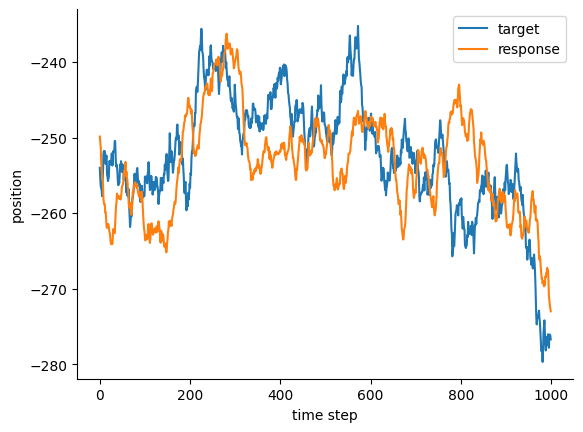

Eigenvalues of controllability Gramian: [    0.    10485.761]


In [13]:
# Set up an agent with an internal model
internal_model_params = env_params.copy()
# internal_model_params["control_gain"] = 2.0  # Agent has a wrong internal model
internal_model = TrackingTaskEnv(params=internal_model_params)

agent = RationalAgent(internal_model=internal_model)
internal_state = state  # Initial internal state is equal to true state

states = []
env.rng = random.PRNGKey(0)
for _ in range(1000):
    # compute the action based on current internal state
    action = agent.behave(internal_state)

    # take a step in the environment
    state, observation, reward = env.step(state, action)
    states.append(state)

    # update the internal state based on agent's action and observation
    internal_state = agent.update_state(internal_state, action, observation)

x = jnp.stack(states)

fig, ax = plt.subplots()
ax.plot(x[:, 0], label="target")
ax.plot(x[:, 1], label="response")
ax.set_xlabel("time step")
ax.set_ylabel("position")
ax.legend()
plt.show()

print(f"Eigenvalues of controllability Gramian: {internal_model.h1_score()}")